In [28]:
import subprocess
import geopandas as gpd
import pandas as pd
import gc
import string
import fiona
import rasterio
import shapely
import contextily as cx
from contextily import Place
from osgeo import gdal
import multiprocessing
import concurrent.futures

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from splot.esda import lisa_cluster, plot_local_autocorrelation, plot_moran
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from splot.esda import moran_scatterplot
import esda
import tqdm
import libpysal as lps
import os
import tempfile
import warnings
from itertools import chain
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

warnings.filterwarnings("ignore")

In [2]:
# configure matplotlib times roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [3]:
# configure data path
current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, "..", "data")

data_path = os.path.normpath(data_path)

# final gdf path
gdf_path = os.path.join(data_path, "final_gdf")

In [4]:
non_contiguous_us_fips = ["02", "15", '60', '66', '69', '72', '78', '81', '84', '86', '67', '89', '71', '76', '95', '79']

In [5]:
# Define U.S. regions and their corresponding states
divisions = {
    "New England": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
    "Middle Atlantic": ["New Jersey", "New York", "Pennsylvania"],
    "East North Central": ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin"],
    "West North Central": ["Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"],
    "South Atlantic": ["Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "District of Columbia", "West Virginia"],
    "East South Central": ["Alabama", "Kentucky", "Mississippi", "Tennessee"],
    "West South Central": ["Arkansas", "Louisiana", "Oklahoma", "Texas"],
    "Mountain": ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming"],
    "Pacific": ["Alaska", "California", "Hawaii", "Oregon", "Washington"]
}

# Load FIPS codes dataset for U.S. states
fips_st_df = pd.read_csv(os.path.join(data_path, "fips_states", "us-state-ansi-fips.csv"))

# Initialize a list to hold DataFrames for each region
us_regions = {}

# Loop through each region and create a DataFrame for states within the region
for division, states in divisions.items():
    # Select states that are in the current region
    states_region_df = fips_st_df[fips_st_df['stname'].isin(states)].copy()
    # Assign the region name to these states
    states_region_df['region'] = division
    states_region_df.columns = [col.strip() for col in states_region_df.columns]
    states_region_df.st = states_region_df.st.astype(str).str.zfill(2)
    us_regions[division] = list(states_region_df.st)


In [6]:
def read_broadband_df(year, level, data_path):
    path = os.path.join(data_path, f"{year}_processed")
    processed_files = [f for f in os.listdir(path) if f.endswith(".csv")]
    column_name = "BLKGRP" if level == 12 else "CNSTRCT"
    dfs = [
        pd.read_csv(os.path.join(path, file)).assign(
            GEOID20=lambda df: df.GEOID20.astype(str).str.zfill(15),
            **{column_name: lambda df: df.GEOID20.str[:level]}
        )
        for file in processed_files
    ]
    return pd.concat(dfs)

In [7]:
def process_file_blocks(args):
    file, state_census_dir = args    
    if file.split("_")[2] not in non_contiguous_us_fips:
        gdf = gpd.read_file(os.path.join(state_census_dir, file))
        gdf["ALAND20"] = gdf["ALAND20"] / 1e6
        gdf = gdf.to_crs("EPSG:5070")
        gdf["Area"] = gdf.geometry.area / 1e6
        gdf["POPDensity"] = gdf["POP20"] / gdf["ALAND20"]
        gdf["POPDenTotalArea"] = gdf["POP20"] / gdf["Area"]
        return gdf[["GEOID20", "ALAND20", "POP20", "POPDensity", "Area", "POPDenTotalArea"]]
    return None

In [8]:
def parallel_process_files(files_dir, data_path, process_function, pool_processes=4):
    state_census_dir = os.path.join(data_path, files_dir)
    census_tract_files = os.listdir(state_census_dir)
    files_with_dir = [(file, state_census_dir) for file in census_tract_files]
    
    print("Processing file blocks...")
    with multiprocessing.Pool(processes=pool_processes) as pool:
        gdfs = list(tqdm.tqdm(pool.imap(process_file_blocks, files_with_dir), total=len(census_tract_files)))
    
    print("Finished processing census block files...")
    return pd.concat([gdf for gdf in gdfs if gdf is not None], ignore_index=True)

In [9]:
def compute_speed_statistics(years, level, data_path, pop_density_df):
    gwm_collector = []  # To collect geographically weighted means for each year
    mean_speed_collector = []  # To collect mean download speeds for each year
    
    print("Computing broadband geographicallyy weighed mean and mean download speed...")

    for year in years:
        df_broadband = read_broadband_df(year, level, data_path)
        merged_broadband_pop = df_broadband.merge(pop_density_df, on="GEOID20")
        gwm = (
            merged_broadband_pop.groupby('CNSTRCT')
            .apply(lambda x: (x['POPDensity'] * x[f'MaxAdDownMedian{year}']).sum() / x['POPDensity'].sum())
            .reset_index(name=f'GeographicallyWeightedMean{year}')
        )
        gwm_collector.append(gwm)

        mean_speed = (
            merged_broadband_pop.groupby('CNSTRCT')[f'MaxAdDownMedian{year}'].mean()
            .reset_index(name=f'MeanDownloadSpeed{year}')
        )
        mean_speed_collector.append(mean_speed)
        
    df_all_years_gwm = gwm_collector[0]
    for gwm_df in gwm_collector[1:]:
        df_all_years_gwm = df_all_years_gwm.merge(gwm_df, on='CNSTRCT', how='inner')

    df_all_years_ms = mean_speed_collector[0]
    for gms_df in mean_speed_collector[1:]:
        df_all_years_ms = df_all_years_ms.merge(gms_df, on='CNSTRCT', how='inner')

    
    print("Finedshed processing broadband speed...")
    return df_all_years_gwm.merge(df_all_years_ms, on='CNSTRCT')

In [10]:
def process_census_file(args):
    file, state_census_dir = args
    if file.split("_")[2] not in non_contiguous_us_fips:
        gdf = gpd.read_file(os.path.join(state_census_dir, file))
        
        gdf = gdf[["GEOID", "STATEFP", "ALAND", "geometry"]]
        
        return gdf

def processes_census_tracts(files_dir):
    state_census_dir = os.path.join(data_path, files_dir)
    census_tract_files = os.listdir(state_census_dir)

    # Prepare an iterable of tuples for the imap function
    files_with_dir = [(file, state_census_dir) for file in census_tract_files]

    # Use a multiprocessing pool to read and process files in parallel
    with multiprocessing.Pool(processes=4) as pool:
        gdfs = list(tqdm.tqdm(pool.imap(process_census_file, files_with_dir), total=len(census_tract_files)))

    # Combine all GeoDataFrames
    combined_gdf = pd.concat(gdfs, ignore_index=True)
    return combined_gdf

In [11]:
def process_read_gdf():
    # State boundaries
    gdf_states_path = os.path.join(data_path, "gdf_state_polygons")
    if not os.path.exists(gdf_path):
    
        files_dir = "CensusBlockShp"
        pop_density_blks_path = os.path.join(data_path, "pop_density_census_blk_areas.csv")

        if not os.path.exists(pop_density_blks_path):
            pop_density_df = parallel_process_files(files_dir, data_path, process_file_blocks)
            pop_density_df.to_csv(pop_density_blks_path, index=False)

        else:
            pop_density_df = pd.read_csv(pop_density_blks_path)
            
        pop_density_df.GEOID20 = pop_density_df.GEOID20.astype(str).str.zfill(15)
        pop_density_df = pop_density_df.dropna(subset=["POPDensity"]).drop_duplicates(subset=["GEOID20"])

        years = [2017, 2018, 2019, 2020, 2021]
        level = 11
        speed_df_path = os.path.join(data_path, "mean_gw_speed.csv")

        if not os.path.exists(speed_df_path):
            df_final_speed = compute_speed_statistics(years, level, data_path, pop_density_df)
            df_final_speed.to_csv(speed_df_path, index=False)
        else:
            df_final_speed = pd.read_csv(speed_df_path)
        
        df_final_speed.CNSTRCT = df_final_speed.CNSTRCT.astype(str).str.zfill(11)

        # Process Census Tract Shapefiles
        files_dir = "CensusTractShp"
        combined_ct_path = os.path.join(data_path, "census_tract_all")

        if not os.path.exists(combined_ct_path):
            combined_gdf = processes_census_tracts(files_dir)
            combined_gdf.to_file(combined_ct_path)
        
        else:

            gdf_cts = gpd.read_file(combined_ct_path)
            
        gdf_cts.STATEFP = gdf_cts.STATEFP.astype(str).str.zfill(2)
        gdf_cts.GEOID = gdf_cts.GEOID.astype(str).str.zfill(11)

        # Merge census tract gdf with broadband speed data
        gdf_weights = gdf_cts.merge(df_final_speed, left_on ="GEOID", right_on="CNSTRCT")
        gdf_weights.STATEFP = gdf_weights.STATEFP.astype(str).str.zfill(2)

        # Load demographic data
        df_dem_factors = pd.read_csv(os.path.join(data_path, "in_urb_ed_brb.csv"))
        df_dem_factors['GEOID'] = df_dem_factors['GEOID'].astype(str).str.zfill(12)
        df_dem_factors['CNSTRCT'] = df_dem_factors['GEOID'].str[:11]
        df_dem_factors = df_dem_factors[df_dem_factors['POP20'] != 0]

        # Impute missing values
        imputation_values = {
            'median_income': df_dem_factors['median_income'].median(),
            'with_degree': df_dem_factors['with_degree'].mean(),
            'urban_pop': df_dem_factors['urban_pop'].mean(),
            'with_broadband': df_dem_factors['with_broadband'].mean()
        }
        df_filled = df_dem_factors.fillna(value=imputation_values)

        # Group by Census Tract
        df_filled = df_filled.groupby('CNSTRCT', as_index=False).agg({
            'median_income': 'median',
            'with_degree': 'mean',
            'urban_pop': 'mean',
            'with_broadband': 'mean'
        })

        # Merge with demographic data
        merged_gdf = gdf_weights.merge(df_filled, on='CNSTRCT')

        # Cap outliers
        outlier_columns = [col for col in df_final_speed.columns if col != "CNSTRCT"]
        for column in outlier_columns:
            merged_gdf.loc[merged_gdf[column] > 999, column] = 999

        # Save the merged data
        merged_gdf.to_file(gdf_path)
        
        # save as GeoJSON
        merged_gdf.to_file("final_gdf.geojson", driver="GeoJSON")

        # Create and save state boundaries
        if not os.path.exists(gdf_states_path):
            gdf_states = merged_gdf.dissolve(by='STATEFP')
            gdf_states.to_file(gdf_states_path)

        # Cleanup
        del gdf_cts, df_final_speed, df_dem_factors, df_filled
        gc.collect()
    
    else:
        # Read final GeoDataFrames
        merged_gdf = gpd.read_file("final_gdf.geojson")
        if not os.path.exists(gdf_states_path):
            gdf_states = merged_gdf.dissolve(by='STATEFP')
            gdf_states.to_file(gdf_states_path)
            
    gdf_states = gpd.read_file(gdf_states_path)
        
    return merged_gdf, gdf_states

In [12]:
merged_gdf, gdf_states = process_read_gdf()

In [13]:
# load existing weights
w = lps.io.open(os.path.join(data_path, "weights.gal")).read()
w.transform = "r"

# fill nas in the merged data columns instead of dropping off
columns_to_fill = ['GeographicallyWeightedMean2017', 'GeographicallyWeightedMean2018',
                   'GeographicallyWeightedMean2019', 'GeographicallyWeightedMean2020',
                   'GeographicallyWeightedMean2021', 'MeanDownloadSpeed2017',
                   'MeanDownloadSpeed2018', 'MeanDownloadSpeed2019',
                   'MeanDownloadSpeed2020', 'MeanDownloadSpeed2021']

# Calculate the mean for each column and fill NaN values with these means
for column in columns_to_fill:
    merged_gdf[column] = merged_gdf[column].fillna(merged_gdf[column].mean())

('WARNING: ', '41761', ' is an island (no neighbors)')
('WARNING: ', '41954', ' is an island (no neighbors)')
('WARNING: ', '68623', ' is an island (no neighbors)')
('WARNING: ', '78795', ' is an island (no neighbors)')


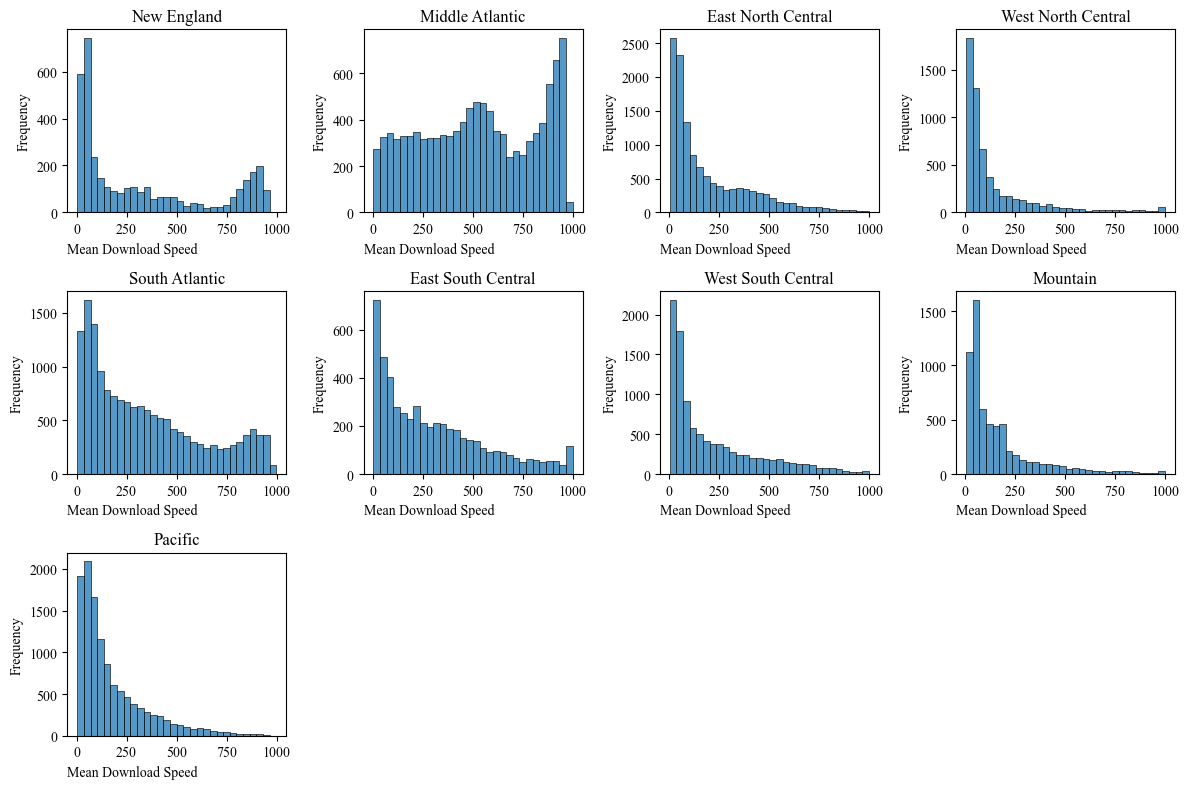

In [14]:
num_regions = len(us_regions)
ncols = 4
nrows = num_regions // ncols + (num_regions % ncols > 0)

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
axes = axes.flatten()

# Plot each region's MeanDownloadSpeed histogram
for idx, (region, ax) in enumerate(zip(us_regions, axes)):
    region_name = region.replace(" ", "").lower()
    gdf = merged_gdf[merged_gdf.STATEFP.isin(us_regions[region])]
    
    sns.histplot(gdf.MeanDownloadSpeed2020, bins=30, ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Mean Download Speed', loc='left')
    ax.set_ylabel('Frequency')

# If there are subplots that are not used, hide them
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust the layout
plt.tight_layout()
plt.show()

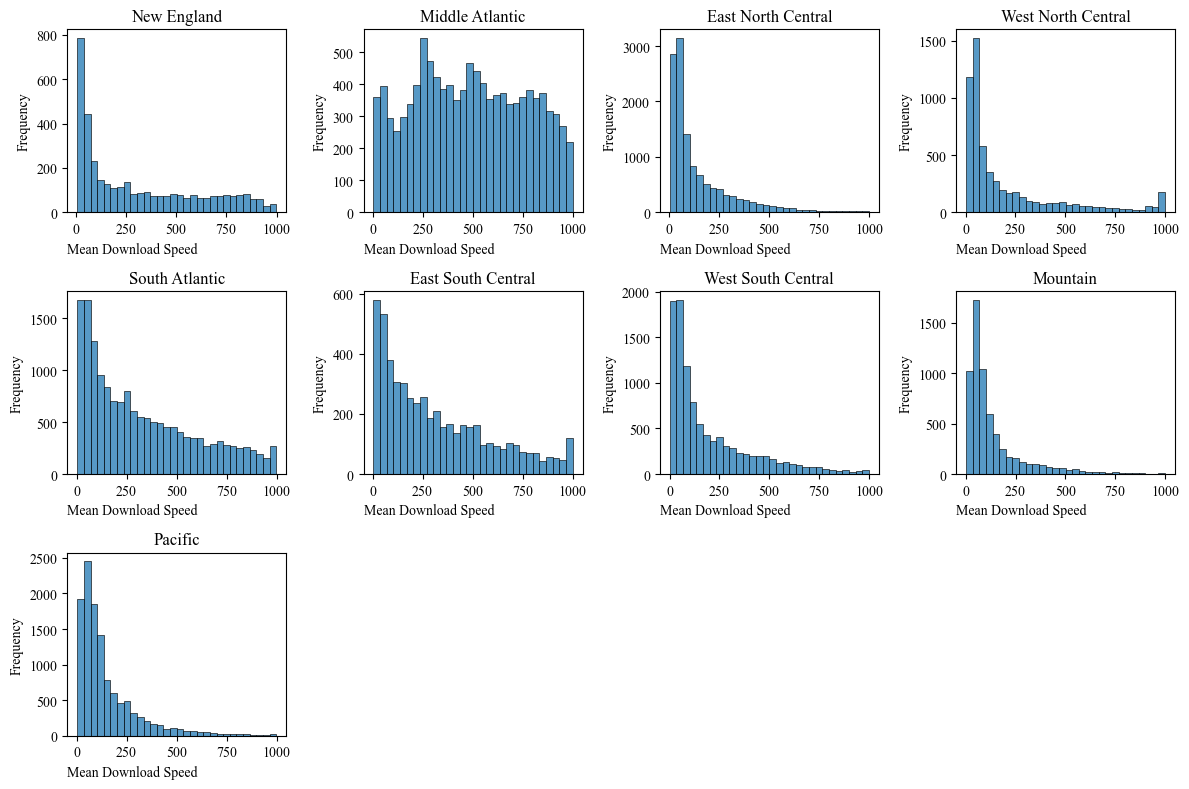

In [15]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
axes = axes.flatten()

# Plot each region's MeanDownloadSpeed histogram
for idx, (region, ax) in enumerate(zip(us_regions, axes)):
    region_name = region.replace(" ", "").lower()
    gdf = merged_gdf[merged_gdf.STATEFP.isin(us_regions[region])]
    sns.histplot(gdf.GeographicallyWeightedMean2021, bins=30, ax=ax)
    ax.set_title(region)
    ax.set_xlabel('Mean Download Speed', loc='left')
    ax.set_ylabel('Frequency')

# If there are subplots that are not used, hide them
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust the layout
plt.tight_layout()
plt.show()

4it [00:56, 14.22s/it]


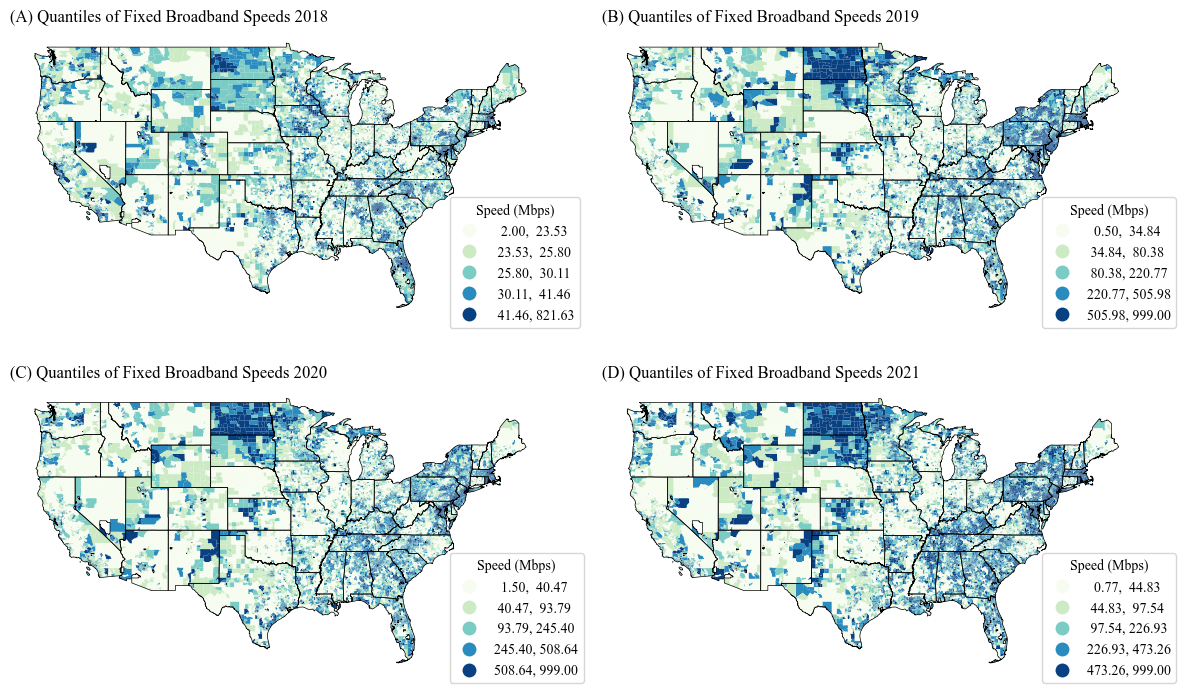

65

In [16]:
us_crs = 'epsg:4269'

# Plot each region, adjusting them to the same CRS
years = [2018, 2019, 2020, 2021]
uppercase_letters = list(string.ascii_uppercase)

ncols = 2  # Adjust the number of columns as needed
nrows = len(years) // ncols + (len(years) % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))

if nrows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, year in tqdm.tqdm(enumerate(years)):
    ax = axes[i]
    
    gdf_copy = merged_gdf.copy()
    
    gdf_copy = gdf_copy.dropna(subset=[f"GeographicallyWeightedMean{year}"])
    gdf_copy.to_crs(us_crs).plot(
        f"GeographicallyWeightedMean{year}",
        legend=True,  # Only need one legend for all plots
        scheme="quantiles",
        cmap="GnBu",
        k=5,
        ax=ax
    )

    gdf_states.to_crs(us_crs).boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    # cx.add_basemap(ax, crs=us_crs, source=cx.providers.OpenStreetMap.Mapnik)
    
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((0.8, 0.2))
    legend.set_loc('center left')
    legend.set_title("Speed (Mbps)")
    ax.set_title(f"({uppercase_letters[i]}) Quantiles of Fixed Broadband Speeds {year}", loc='left')
    ax.axis("off")
    ax.set_facecolor('grey') 

    # Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Ensure everything fits neatly
plt.tight_layout()

# Display the plot
plt.show()

# save fig
fig_name = "spatial_dist_broadband.png"
fig.savefig(os.path.join("..", "figures", fig_name))

del gdf_copy
gc.collect()

4it [01:03, 15.93s/it]


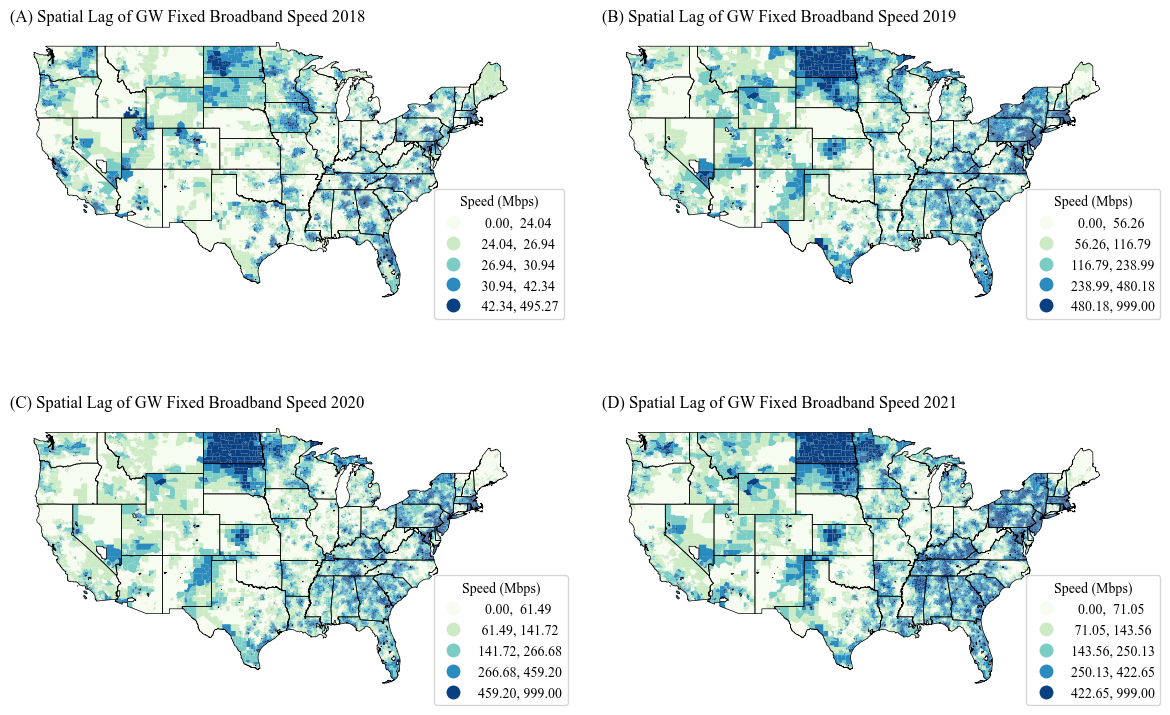

37

In [17]:
ncols = 2 
nrows = len(years) // ncols + (len(years) % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))

if nrows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, year in tqdm.tqdm(enumerate(years)):
    ax = axes[i]
    
    gdf_copy = merged_gdf.copy()
    
    gdf_copy = gdf_copy.dropna(subset=[f"GeographicallyWeightedMean{year}"])
    y = gdf_copy[f"GeographicallyWeightedMean{year}"]
    ylag = lps.weights.lag_spatial(w, y)

    # Plot the spatial lag values
    gdf_copy.assign(cl=ylag).to_crs(us_crs).plot(
        column='cl',
        scheme="quantiles",
        legend=True,
        k=5,
        cmap="GnBu",
        ax=ax
    )

    gdf_states.to_crs(us_crs).boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    # cx.add_basemap(ax, crs=us_crs, source=cx.providers.OpenStreetMap.Mapnik)
    
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((0.8, 0.2))
    legend.set_title("Speed (Mbps)")
    legend.set_loc('center left')
    ax.set_title(f"({uppercase_letters[i]}) Spatial Lag of GW Fixed Broadband Speed {year}", loc='left')
    ax.axis("off")
    ax.set_facecolor('grey') 

    # Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Adjust the layout
plt.tight_layout()
plt.show()

# save fig
fig_name = "spatial_lag.png"
fig.savefig(os.path.join("..", "figures", fig_name))

del gdf_copy
gc.collect()

### Moran's I

4it [00:52, 13.22s/it]


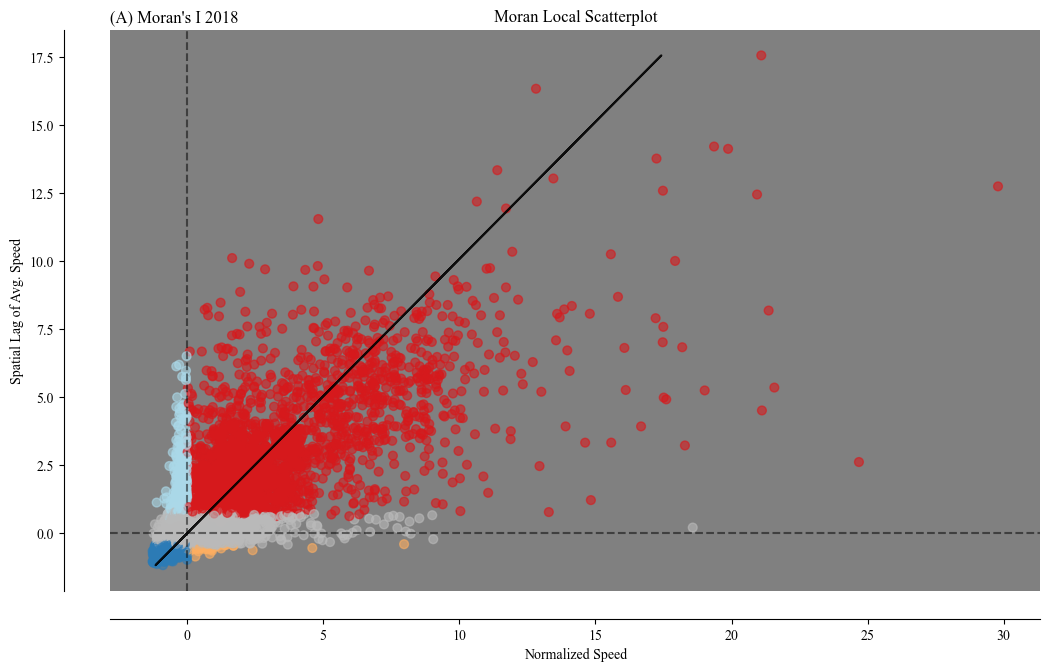

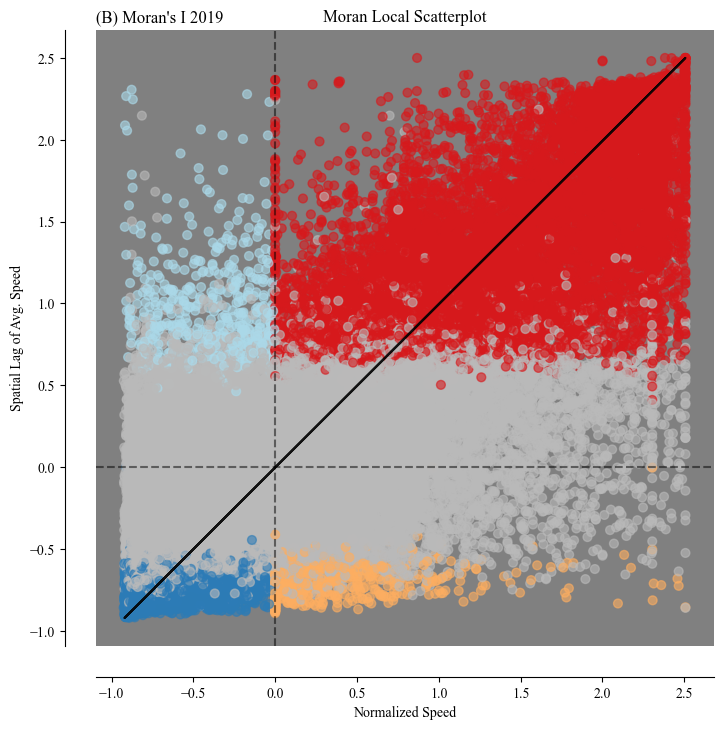

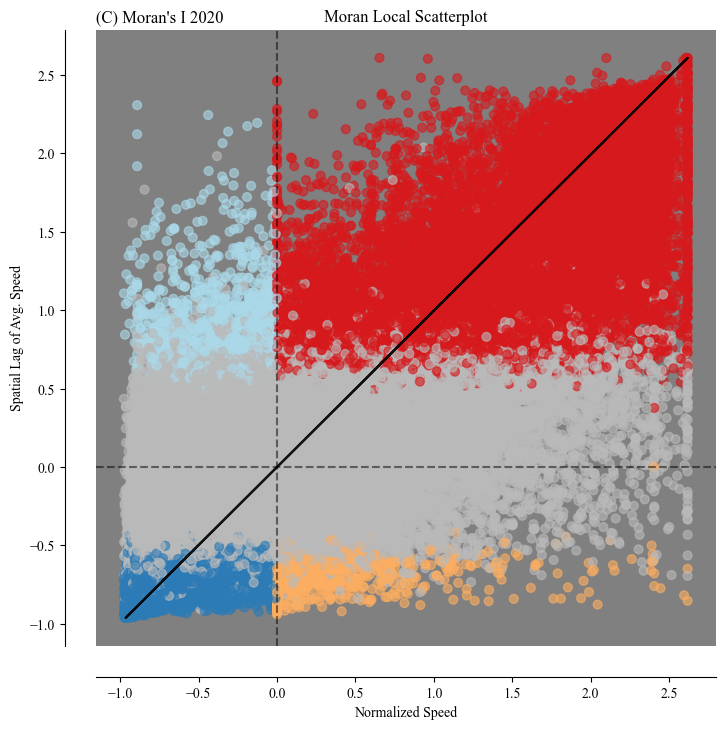

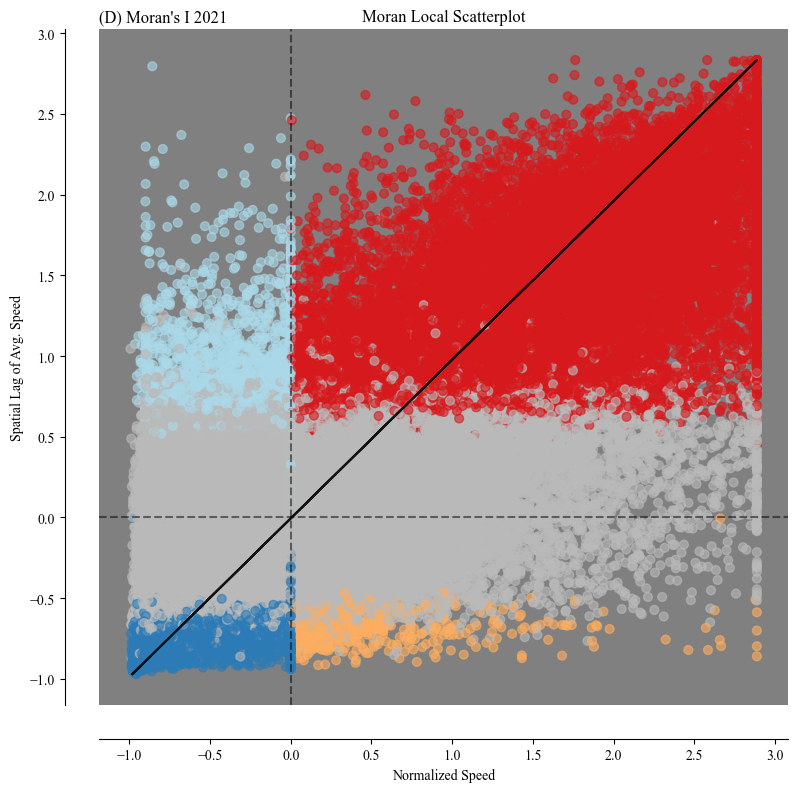

10205

In [18]:
for i, year in tqdm.tqdm(enumerate(years)):
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    gdf_copy = merged_gdf.copy()
    
    gdf_copy = gdf_copy.dropna(subset=[f"GeographicallyWeightedMean{year}"])
    y = gdf_copy[f"GeographicallyWeightedMean{year}"]

    # Compute local Moran's I
    moran = esda.Moran_Local(y, w)
    moran_scatterplot(moran, ax=ax, p=0.05)
        
    ax.set_title(f"({uppercase_letters[i]}) Moran's I {year}", loc='left')
    ax.set_facecolor('grey')
    ax.set_xlabel('Normalized Speed')
    ax.set_ylabel('Spatial Lag of Avg. Speed')
    
plt.tight_layout()
plt.show()
    

# # save fig
# fig_name = "global_moran_I_plot.png"
# fig.savefig(os.path.join("..", "figures", fig_name))

del gdf_copy
gc.collect()

4it [03:51, 57.98s/it]


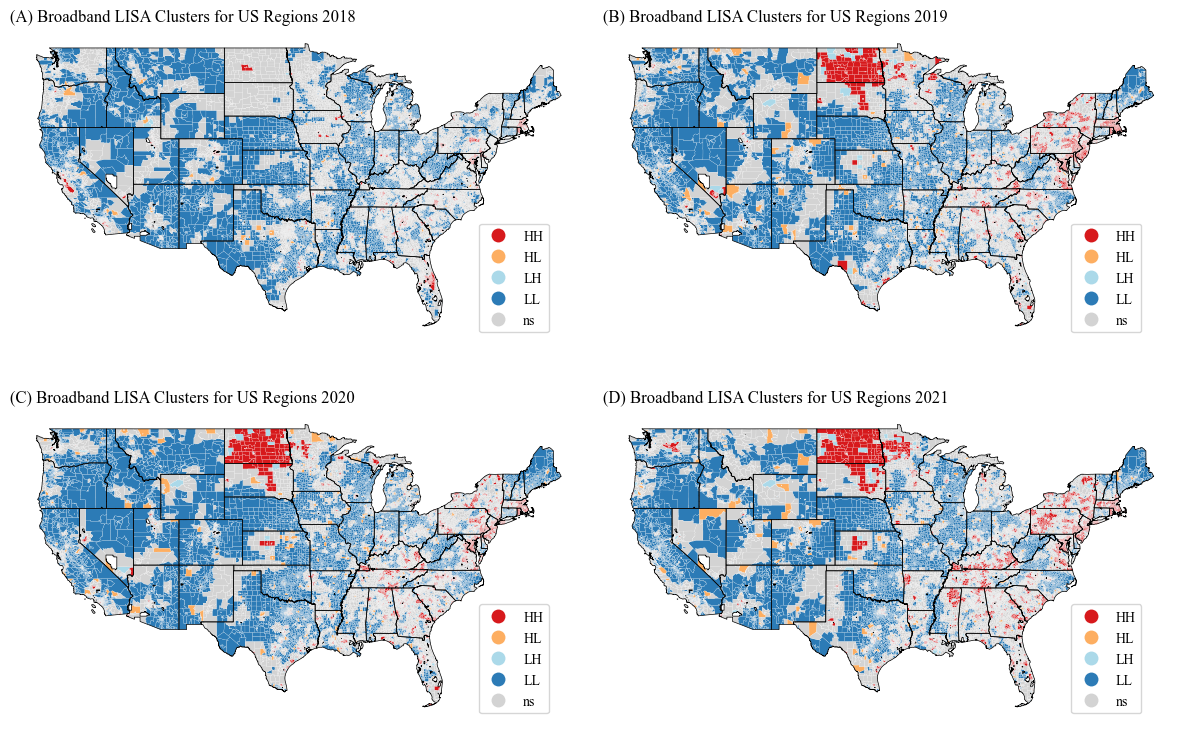

0

In [19]:
ncols = 2 
nrows = len(years) // ncols + (len(years) % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))

if nrows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, year in tqdm.tqdm(enumerate(years)):
    ax = axes[i]

    gdf_copy = merged_gdf.copy()
    
    gdf_copy = gdf_copy.dropna(subset=[f"GeographicallyWeightedMean{year}"])
    y = gdf_copy[f"GeographicallyWeightedMean{year}"]

    moran = esda.Moran_Local(y, w)

    lisa_cluster(moran, gdf_copy, p=0.05, ax=ax)

    gdf_states.to_crs(us_crs).boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    # cx.add_basemap(ax, crs=us_crs, source=cx.providers.OpenStreetMap.Mapnik)
    
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((0.8, 0.2))
    legend.set_loc('center left')
    ax.set_title(f"({uppercase_letters[i]}) Broadband LISA Clusters for US Regions {year}", loc='left')
    ax.axis("off")
    ax.set_facecolor('grey') 

    # Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

gc.collect()

fig_name = "lisa_clusters.png"
fig.savefig(os.path.join("..", "figures", fig_name))

del gdf_copy
gc.collect()

### Stochastic analysis of broadband distribution

In [33]:
gwm_broadb = merged_gdf[['GeographicallyWeightedMean2017', 'GeographicallyWeightedMean2018','GeographicallyWeightedMean2019', 'GeographicallyWeightedMean2020','GeographicallyWeightedMean2021']].values.T
mean_broadb = merged_gdf[['MeanDownloadSpeed2017','MeanDownloadSpeed2018', 'MeanDownloadSpeed2019','MeanDownloadSpeed2020', 'MeanDownloadSpeed2021', 'median_income']].values

In [34]:
mits = [esda.Moran(year_dat, w) for year_dat in gwm_broadb]

years = np.arange(2017,2022)
res = np.array([(mi.I, mi.EI, mi.seI_norm, mi.sim[974]) for mi in mits])

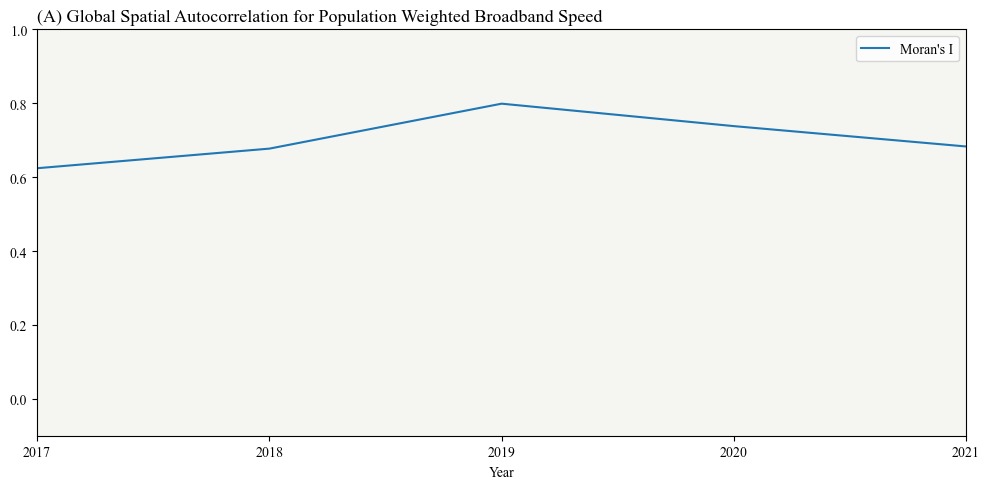

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(years, res[:, 0], label="Moran's I")
ax.set_title("(A) Global Spatial Autocorrelation for Population Weighted Broadband Speed", 
             fontsize=13, loc='left')
ax.set_xlim([2017, 2021])
ax.set_ylim([-0.1, 1])
ax.set_xlabel("Year")
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_facecolor('#f5f5f2')

ax.legend()

plt.tight_layout()
plt.show()

fig_name = "global_autocorr.png"
fig.savefig(os.path.join("..", "figures", fig_name))

In [36]:
# LISA Markov
import giddy

lisa_markov = giddy.markov.LISA_Markov(gwm_broadb.T, w)
print(lisa_markov.classes)

[1 2 3 4]


In [37]:
# print the cumulative sum of transitions

lisa_markov.transitions

array([[ 60330.,   7719.,  21558.,   4689.],
       [  6318.,   7551.,   8228.,    489.],
       [ 21771.,   9945., 155882.,   8789.],
       [  5140.,    540.,   8279.,   5608.]])

In [38]:
# global probabilities
lisa_markov.p

lisa_classes = ["HH", "LH", "LL", "HL"]

lisa_df = pd.DataFrame(np.round(lisa_markov.p, 2), columns=lisa_classes)
lisa_df.index = lisa_classes

lisa_df.to_csv(os.path.join("..", "figures", "lisa_clusers.csv"))

In [39]:
print(lisa_markov.steady_state)

[0.28325805 0.08116086 0.57716635 0.05841473]


In [40]:
print(giddy.ergodic.fmpt(lisa_markov.p))

[[ 3.53034975 16.32735003  3.92471351 22.44591694]
 [ 5.87568198 12.32121035  3.24814925 23.32407924]
 [ 7.62598018 17.48284775  1.73260273 22.63955131]
 [ 6.15197064 17.78279788  2.97256451 17.11896873]]


## Geographically Weighted Regression

In [41]:
merged_gdf[["with_degree", "urban_pop", "with_broadband"]] = merged_gdf[["with_degree", "urban_pop", "with_broadband"]]*100

# sample a few items to select bandwidth
# bandwidth_selector


In [49]:
merged_gdf

GEOID STATEFP      ALAND      CNSTRCT  \
0      19055950300      19   27142261  19055950300   
1      19055950400      19  735669629  19055950400   
2      19055950200      19  355629133  19055950200   
3      19055950100      19  377752377  19055950100   
4      19169001200      19     292480  19169001200   
...            ...     ...        ...          ...   
83204  36081027900      36     177155  36081027900   
83205  36081028000      36     165398  36081028000   
83206  36081028100      36     174441  36081028100   
83207  36081028200      36     182472  36081028200   
83208  36081028400      36     429455  36081028400   

       GeographicallyWeightedMean2017  GeographicallyWeightedMean2018  \
0                           26.484879                       35.328511   
1                           21.716848                       27.680729   
2                           25.963462                       45.363952   
3                           26.903063                       34.292147   
4                           10.000000                       25.000000   
...                               ...                             ...   
83204                       26.058795                       29.551463   
83205                       27.500000                       30.000000   
83206                       26.045179                       29.734517   
83207                       27.500000                       30.000000   
83208                       27.568103                       30.136206   

       GeographicallyWeightedMean2019  GeographicallyWeightedMean2020  \
0                           65.043882                       47.950810   
1                           53.752818                       35.152232   
2                           62.484592                      104.780001   
3                           61.968090                       53.160345   
4                            6.000000                      505.000000   
...                               ...                             ...   
83204                      898.510356                      655.648577   
83205                      940.000000                      818.501650   
83206                      876.078652                      689.877851   
83207                      940.000000                      940.000000   
83208                      940.000000                      940.000000   

       GeographicallyWeightedMean2021  MeanDownloadSpeed2017  \
0                          113.666412              25.158385   
1                           76.833734              20.072056   
2                          170.539119              21.191126   
3                           79.346209              22.839564   
4                           25.000000              14.250000   
...                               ...                    ...   
83204                      317.304618              26.000000   
83205                      744.388082              27.500000   
83206                      401.218940              25.250000   
83207                      925.229765              27.500000   
83208                      838.076991              27.604167   

       MeanDownloadSpeed2018  MeanDownloadSpeed2019  MeanDownloadSpeed2020  \
0                  32.962733              57.779503              49.173913   
1                  26.158172              51.141037              40.528120   
2                  28.090444              46.090444              53.466724   
3                  27.420561              48.161215              40.408879   
4                  25.000000               8.000000             265.000000   
...                      ...                    ...                    ...   
83204              29.500000             893.750000             665.500000   
83205              30.000000             940.000000             802.750000   
83206              29.000000             871.750000             665.500000   
83207              30.000000             940.000000          

In [42]:
import random

In [55]:
def bandwidth_selector():
    """
    Selects a bandwidth for a Geographically Weighted Regression (GWR) model
    by randomly choosing a US region and fitting a GWR model on data from that region.
    
    Returns:
        The fit results of the GWR model.
    """
    # Randomly select a region and its states
    us_region_keys = list(us_regions.keys())
    region_states = us_regions[us_region_keys[random.randrange(len(us_regions))]]

    # Filter dataframe for the selected region
    region_gdf = merged_gdf[merged_gdf.STATEFP.isin(region_states)]

    # Prepare data and coordinates
    g_X = region_gdf[["with_degree","with_broadband"]].values
    g_y2 = region_gdf.MeanDownloadSpeed2021.values.reshape((-1, 1))
    g_coords = list(zip(region_gdf.geometry.centroid.x.values,
                        region_gdf.geometry.centroid.y.values))

    # Standardize X and Y data
    g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
    g_y2 = (g_y2 - g_y2.mean(axis=0)) / g_y2.std(axis=0)

    # Bandwidth selection and GWR model fitting
    gwr_selector = Sel_BW(g_coords, g_y2, g_X)
    gwr_bw = gwr_selector.search(bw_min=2)
    gwr_results = GWR(g_coords, g_y2, g_X, gwr_bw).fit()
    
    # Optional: Print summary of GWR model results
    # gwr_results.summary()

    return gwr_results

In [56]:
gwr_results = bandwidth_selector()

In [74]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               16483
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          15678.220
Log-likelihood:                                                  -22975.819
AIC:                                                              45957.638
AICc:                                                             45959.640
BIC:                                                            -144343.978
R2:                                                                   0.049
Adj. R2:                                                              0.049

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [71]:
data = {
    'R2': [gwr_results.R2],
    'Adjusted R2': [gwr_results.adj_R2],
    'AIC': [gwr_results.aic],
    'BIC': [gwr_results.bic],
    'Degrees of Freedom (Model)': [gwr_results.df_model],
    'Degrees of Freedom (Residual)': [gwr_results.df_resid],
    # Add coefficients (params) - assuming they are in a list or similar structure
    'Coefficients': [list(gwr_results.params)]
}

# Convert the dictionary to a DataFrame
df_summary = pd.DataFrame(data)

# Save to a CSV file
df_summary.to_csv('gwr_summary.csv', index=False)

In [73]:
df_summary

R2  Adjusted R2           AIC           BIC  \
0  0.755375     0.701089  29556.871593  52643.396974   

   Degrees of Freedom (Model)  Degrees of Freedom (Residual)  \
0                13489.671675                   12512.592269   

                                        Coefficients  
0  [[-0.9303639070867609, 0.07096153051171139, 0....

## Load the Landsat data

In [57]:
# # clipping virginia from the reclassified image
# gdf_projected = gdf.to_crs(albers_projection)

# # boundary
# virginia_boundary = gdf_projected.dissolve()

# def clip_tiff_by_gdf(tiff_path, gdf, output_tiff_path):
    
#     # Create a temp file
#     with tempfile.TemporaryDirectory() as tmpdirname:
#         temp_shapefile_path = os.path.join(tmpdirname, "temp_boundary.shp")
#         gdf.to_file(temp_shapefile_path)

#         # GDAL Warp command to clip the raster with the shapefile
#         gdal.Warp(
#             output_tiff_path,
#             tiff_path,
#             cutlineDSName=temp_shapefile_path,
#             cropToCutline=True,
#             dstNodata=-9999,
#         )

# # paths to your files
# clipped_virginia_tiff_path = os.path.join(data_path, "landcover", "virginia_only.tif")

# # clip the TIFF
# clip_tiff_by_gdf(lc_path, virginia_boundary, clipped_virginia_tiff_path)

Warning 1: for band 1, destination nodata value has been clamped to -128, the original value being out of range.


In [74]:
# def clip_and_count_values(tiff_path, gdf, output_folder):
    
#     results = []

#     # Ensure the output folder exists
#     os.makedirs(output_folder, exist_ok=True)

#     # Iterate over each tract in the GeoDataFrame
#     for index, row in gdf.iterrows():
#         tract_id = row['GEOID']  # Replace 'GEOID' with your actual column name for the tract ID

#         # Create a temporary GeoDataFrame for the current tract
#         temp_gdf = gpd.GeoDataFrame([row], crs=gdf.crs)

#         with tempfile.TemporaryDirectory() as tmpdirname:
#             temp_shapefile_path = os.path.join(tmpdirname, f"temp_tract_{tract_id}.shp")
#             temp_gdf.to_file(temp_shapefile_path)

#             # Use GDAL's in-memory file system for clipping
#             output_tiff_path = '/vsimem/clipped_tract.tif'

#             # GDAL Warp command to clip the raster with the shapefile
#             gdal.Warp(
#                 output_tiff_path,
#                 tiff_path,
#                 cutlineDSName=temp_shapefile_path,
#                 cropToCutline=True,
#                 dstNodata=-9999,
#             )

#             # Use rasterio to read the clipped raster from memory
#             with rasterio.open(output_tiff_path) as src:
#                 raster_data = src.read(1)  # Read the first band

#                 # Count specific values
#                 count_0_1 = np.count_nonzero(np.isin(raster_data, [0, 1]))
#                 count_21_24 = np.count_nonzero(np.isin(raster_data, [21, 22, 23, 24]))

#                 # Append results
#                 results.append((tract_id, count_0_1, count_21_24))

#             # Free memory by deleting the in-memory raster
#             gdal.Unlink(output_tiff_path)

#     return results




In [ ]:
# lc_path = os.path.join(data_path, "landcover", "outOriginalReclassified.tiff")

# landcover = gdal.Open(lc_path, gdal.GA_ReadOnly)

# albers_projection = """
#     PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",
#     SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],
#     AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],
#     UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],
#     AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],
#     PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],
#     PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],
#     PARAMETER["false_easting",0],PARAMETER["false_northing",0],
#     UNIT["metre",1,AUTHORITY["EPSG","9001"]],
#     AXIS["Easting",EAST],AXIS["Northing",NORTH]]
# """

# def clip_and_count_values_worker(args):
#     tiff_path, gdf_row, output_folder = args
#     tract_id = gdf_row['GEOID']
#     temp_gdf = gpd.GeoDataFrame([gdf_row], crs=albers_projection)

#     with tempfile.TemporaryDirectory() as tmpdirname:
#         temp_shapefile_path = os.path.join(tmpdirname, f"temp_tract_{tract_id}.shp")
#         temp_gdf.to_file(temp_shapefile_path)

#         output_tiff_path = '/vsimem/clipped_tract.tif'
#         gdal.Warp(output_tiff_path, tiff_path, cutlineDSName=temp_shapefile_path, cropToCutline=True, dstNodata=-9999)

#         with rasterio.open(output_tiff_path) as src:
#             raster_data = src.read(1)
#             count_0_1 = np.count_nonzero(np.isin(raster_data, [0, 1]))
#             count_21_24 = np.count_nonzero(np.isin(raster_data, [21, 22, 23, 24]))

#         gdal.Unlink(output_tiff_path)
#         return (tract_id, count_0_1, count_21_24)

# def process_tracts_in_batches(tiff_path, gdf, output_folder, batch_size=100):
#     # Divide the GeoDataFrame into batches
#     batches = [gdf.iloc[i:i + batch_size] for i in range(0, len(gdf), batch_size)]
#     results = []

#     # Process each batch
#     for batch in tqdm.tqdm(batches):
#         tasks = [(tiff_path, row, output_folder) for _, row in batch.iterrows()]
#         with multiprocessing.Pool() as pool:
#             batch_results = pool.map(clip_and_count_values_worker, tasks)
#             results.extend(batch_results)

#     return results

# output_folder = os.path.join(data_path, "landcover", "tracts")

# census_tract_files = os.listdir(state_census_dir)
# # tracts = []

# # for file in tqdm.tqdm(census_tract_files):
# #     if file.split("_")[2] not in non_contiguous_us_fips:
# #         gdf = gpd.read_file(os.path.join(state_census_dir, file))
# #         gdf["GEOID"] = gdf["GEOID"].astype(int)
# #         gdf_projected = gdf.to_crs(albers_projection)

# #         # Process the tracts in batches
# #         tract_counts = process_tracts_in_batches(lc_path, gdf_projected, output_folder)
# #         tracts.append(tract_counts)

In [75]:
# flattened_list_of_tuples = list(chain.from_iterable(tracts))

# df_tracts_count = pd.DataFrame(flattened_list_of_tuples, columns=['tract_id', 'count_0_1', 'count_21_24'])

In [118]:
# df_tracts_count.tract_id = df_tracts_count.tract_id.astype(str).str.zfill(11)
# df_tracts_count = df_tracts_count[df_tracts_count['count_21_24'] + df_tracts_count['count_0_1'] != 0]

# df_tracts_count["percentage_developed"] = df_tracts_count.apply(lambda row: row["count_21_24"]/(row["count_21_24"]+row["count_0_1"]), axis=1)

# # multiply by the spatial resolution of 30 to get area
# df_tracts_count["area(km2)"] = df_tracts_count.apply(lambda row: (30**2 * (row["count_21_24"]+row["count_0_1"]))/(1000**2),axis=1)

In [133]:
# # groupby census_tract
# df = pd.read_csv(os.path.join(data_path, "in_urb_ed_brb.csv"))
# result = (
#     df.groupby("census_tract")
#     .agg(
#         {
#             "median_income": "median",
#             "with_degree": "mean",
#             "urban_pop": "mean",
#             "with_broadband": "mean",
#             "POP20": "sum"
#         }
#     )
#     .reset_index()
# )

# result.census_tract = result.census_tract.astype(str).str.zfill(11)